In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

c:\Users\Acer\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:91: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/list/data_name/mnist_784/limit/2/data_version/1. Retrying...
  warn(
c:\Users\Acer\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [6]:
X,y = mnist['data'], mnist['target']

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black)

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[0:1]
some_digit_image = some_digit.values.reshape(28,28)


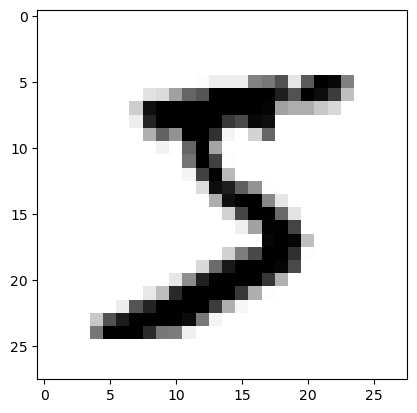

In [15]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.show()

In [16]:
y[0:1]

0    5
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [22]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state= 42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [23]:
sgd_clf.predict(some_digit)

array(['3'], dtype='<U1')